In [2]:
import numpy as np
import pandas as pd
import os 
import warnings
warnings.filterwarnings('ignore') # to hide warnings such as 'Gensims: detected Windows', and to hide deprecation warnings for TF's random seed

from IPython.display import display # to display DataFrames
import matplotlib.pyplot as plt
%matplotlib inline

import data_utils
import text_utils
import display_utils

from time import time as now

In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huzefaraja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/huzefaraja/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
all_data = pd.read_csv("songdata.csv")
print("Number of songs in the CSV: " + str(len(all_data)))

all_data = all_data.dropna(axis=0, how='any')[['artist', 'song', 'link', 'text']].reset_index(drop=True)
print("Number of songs in the CSV after removing missing data: " + str(len(all_data)))

Number of songs in the CSV: 57650
Number of songs in the CSV after removing missing data: 57650


Data Preprocessing

Below, we remove songs by a few of the artists, and then take the top 500 artists from the remainder of the dataset. Duplicate songs by the same artists are dropped, and songs that have identical lyrics are only kept once.

In [4]:
data_to_use = all_data[~all_data['artist'].isin(set(['chris-brown','american-idol', 'chumbawamba', 
                                                     'celine-dion', '50-cent', 'chamillionaire', '2pac',
                                                     'frank-zappa','2-chainz','beenie-man', 'akon','ace-hood']))]

n_artists = 500
artists = set(data_to_use['artist'].value_counts()[:n_artists].keys())

data_to_use = data_to_use[data_to_use['artist'].isin(artists)]
print('Number of songs: {0}'.format(len(data_to_use)))

data_to_use = data_to_use.drop_duplicates(subset=['artist', 'song']) # same song from same artist
data_to_use = data_to_use.drop_duplicates(subset=['text']).reset_index(drop=True) # songs with identical lyricss
print('Number of songs after dropping duplicates: {0}'.format(len(data_to_use)))

print("Sample Data: ")
display(data_to_use.sample(5, random_state = 1))

Number of songs: 54837
Number of songs after dropping duplicates: 54685
Sample Data: 


,artist,song,link,text
4989,Emmylou Harris,If I Could Be There,/e/emmylou+harris/if+i+could+be+there_20050022...,If I could be there I'd be there tonight comfo...
33162,Gucci Mane,My Chain,/g/gucci+mane/my+chain_20762486.html,My Chain My Chain don't You Like My Chain Mane...
42445,Moody Blues,The Voice,/m/moody+blues/the+voice_20095807.html,Won't you take me back to school? \nI need to...
43642,Nicki Minaj,Hell Yeah,/n/nicki+minaj/hell+yeah_21049867.html,Swear to god I aint see you in the stores yet ...
31619,Garth Brooks,The Gift,/g/garth+brooks/the+gift_20057970.html,A poor orphan girl named Maria \nWas walking ...


In [5]:
data = data_utils.process_data(data_to_use)
print('Saving processed data ... ', end='')
%time data.to_csv('processed_data.csv',encoding='utf-8', index=False)

before:   artist                   song                                        link  \
0   ABBA  Ahe's My Kind Of Girl  /a/abba/ahes+my+kind+of+girl_20598417.html   
1   ABBA       Andante, Andante       /a/abba/andante+andante_20002708.html   
2   ABBA         As Good As New        /a/abba/as+good+as+new_20003033.html   
3   ABBA                   Bang                  /a/abba/bang_20598415.html   
4   ABBA       Bang-A-Boomerang      /a/abba/bang+a+boomerang_20002668.html   

                                                text  
0  Look at her face, it's a wonderful face  \nAnd...  
1  Take it easy with me, please  \nTouch me gentl...  
2  I'll never know why I had to go  \nWhy I had t...  
3  Making somebody happy is a question of give an...  
4  Making somebody happy is a question of give an...  
Cleaning lyrics, counting words and detecing language. This may take some time ... 12m 23s 709ms
after:   artist                   song                                        link  \
0   

# Data Preprocessing Checkpoint

The preprocessing above is a time consuming process. If it has already been performed, 
the next cell can be executed without repeating it (thought the earlier imports are still necessary).

In [5]:
print("Loading processed data ... ", end='')
last = now()
data = pd.read_csv('processed_data.csv')
data = data[['artist', 'song', 'old_word_count', 'cleaned_lyrics', 'new_word_count']]
display_utils.print_time(now() - last)
print("Number of processed songs: %d" % len(data))

Loading processed data ... 805ms
Number of processed songs: 54685


In [6]:
df_orig = data_utils.get_songs_with_min_length(data, 100)
print("Number of songs remaining: %d " % len(df_orig))

Removing songs with word count less than 100 ... 4ms
Number of songs remaining: 6156 


In [7]:
print("A sample of the number of songs by different artists: ")
display(df_orig.artist.value_counts().sample(5, random_state=23))

A sample of the number of songs by different artists: 


NOFX                5
Rammstein           4
Ofra Haza           8
Neil Young          7
Luther Vandross    18
Name: artist, dtype: int64


# EmoLex

In [8]:
print(df_orig)

            artist                                      song  old_word_count  \
0             ABBA                                 Cassandra             361   
1             ABBA                     Fernando (In Spanish)             248   
2             ABBA  From A Twinkling Star To A Passing Angel             368   
3             ABBA                           Head Over Heels             305   
4             ABBA                         Hole In Your Soul             356   
...            ...                                       ...             ...   
6151     Zebrahead                                 I'm Money             398   
6152     Zebrahead                              Just The Tip             492   
6153     Zebrahead                                 Let Me Go             435   
6154     Zebrahead                             Mental Health             388   
6155  Ziggy Marley                             Hand To Mouth             579   

                                       

In [20]:
nrc = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', delimiter='\t')
nrc.columns = ["word", "emotion", "active"]
def word_to_emotion(row):
    global df_w2e
    w2e = {}
    w2e = {'word':row['word'][row['word'].index[0]]}
    s = 0
    for index, value in row['emotion'].iteritems():
        is_active = row['active'][index]
        w2e[value] = is_active
        s += is_active
    df_w2e = df_w2e.append(w2e, ignore_index=True)
    
df_w2e = pd.DataFrame(columns=['word', 
                               'anger', 'anticipation', 
                               'disgust', 'fear', 
                               'joy', 'sadness', 
                               'surprise', 'trust', 
                               'sum'])
nrc.groupby(by=['word']).apply(word_to_emotion)
df_w2e['sum'] = df_w2e.anger + df_w2e.anticipation + df_w2e.disgust + df_w2e.fear + df_w2e.joy + df_w2e.sadness + df_w2e.surprise + df_w2e.trust
df_w2e.to_csv('word_to_emotion.csv', encoding='utf-8', index=False)

In [90]:
print(nrc)

         word       emotion  active
0       aback  anticipation       0
1       aback       disgust       0
2       aback          fear       0
3       aback           joy       0
4       aback      negative       0
...       ...           ...     ...
141814   zoom      negative       0
141815   zoom      positive       0
141816   zoom       sadness       0
141817   zoom      surprise       0
141818   zoom         trust       0

[141819 rows x 3 columns]


# Another Data Checkpoint
We can continue from below (after loading the previous checkpoint CSV), if the second dataset has already been parsed.

In [22]:
df_w2e = pd.read_csv('word_to_emotion.csv')
df_w2e = df_w2e[df_w2e['sum'] != 0]
words_w2e = [value for idx, value in df_w2e['word'].iteritems()]

# Vectorization

# Creating the Word2Vec model

The cell below will split the lyrics into lists of words, which will then be used to create a Word2Vec Model.

In [23]:
lyrics_raw_orig = df_orig.cleaned_lyrics.values
lyrics_raw_words_orig = [lines.split() for lines in lyrics_raw_orig]

In [24]:
from gensim.models.word2vec import Word2Vec
w2v_model = Word2Vec(lyrics_raw_words_orig, 
                     workers=1, # to ensure that the model is deterministic
                     size=200, min_count=50, 
                     window=10, sample=1e-3)


Let's see how well the model performs:

In [25]:
data_utils.get_similar_words(w2v_model, 'father', min_relevance=.6)

{'daddy', 'mother', 'son'}

That seems to be good. The vocabulary of this model will now be combined with emotion carrying 
words from the Emotion-Lexicon database. This will tell us the number of allowed words:

In [26]:
words_w2v = set(w2v_model.wv.vocab.keys())
words_w2v.update(words_w2e)
#words_w2v.remove('don')
print("Number of words allowed: %d" % (len(words_w2v)))

Number of words allowed: 6340


The two cells below will remove words that are not allowed and update the dataset:

In [27]:
lyrics_raw_words = lyrics_raw_words_orig
lyrics_raw = []
for lyrics in lyrics_raw_words:
    lyrics_raw.append(' '.join([word for word in lyrics if word in words_w2v]))

In [28]:
df_temp = df_orig
df_temp['constrained_lyrics'] = lyrics_raw
df_temp['constrained_word_count'] = df_temp['constrained_lyrics'].apply(lambda x: len(x.split()))
df_temp = df_temp[df_temp.constrained_word_count>=90]
df_temp = df_temp.dropna(how='any')
df = df_temp.reset_index(drop=True)
lyrics_raw = df.constrained_lyrics.values

# CountVectorizer

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(strip_accents = 'unicode',
                                lowercase = True,
                                stop_words = 'english',
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
lyrics_vectorized = vectorizer.fit_transform(lyrics_raw)
print("Number of documents: {0}, number of words: {1}".format(lyrics_vectorized.shape[0], lyrics_vectorized.shape[1]))

Number of documents: 4749, number of words: 2808


# Topic Modeling

In [39]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 70 # number of topics

topic_model = LatentDirichletAllocation(n_components=n_topics, random_state=8, learning_method='online', max_iter=30)
print("Creating Topic Model using LDA with {} iterations ... ".format(topic_model.max_iter), end='')
%time topic_model.fit(lyrics_vectorized)

Creating Topic Model using LDA with 30 iterations ... CPU times: user 3min 2s, sys: 17.7 s, total: 3min 20s
Wall time: 1min 15s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=70, n_jobs=None,
                          perp_tol=0.1, random_state=8, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [40]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(topic_model, lyrics_vectorized, vectorizer, sort_topics=False, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.041780  0.394317       1        1  2.566101
1      0.070248 -0.512770       2        1  0.678308
2     -0.172363 -0.079433       3        1  2.703727
3      0.045582  0.002235       4        1  0.012891
4      0.090687  0.522788       5        1  0.614342
...         ...       ...     ...      ...       ...
65     0.001226  0.009993      66        1  0.022602
66    -0.476048 -0.202657      67        1  0.751526
67    -0.108608  0.015386      68        1  8.298486
68    -0.166375 -0.236002      69        1  1.864008
69    -0.471821  0.145926      70        1  0.800134

[70 rows x 5 columns], topic_info=     Category          Freq     Term         Total  loglift  logprob
1442  Default  12272.000000     love  12272.000000  30.0000  30.0000
92    Default   6583.000000     baby   6583.000000  29.0000  29.0000
1009  Default   4028.000000     girl   4028.000000  28.0000  28.0000
1026  Default   3383.000000     good   3383.000000  27.0000  27.0000
845   Default   3749.000000     feel   3749.000000  26.0000  26.0000
...       ...           ...      ...           ...      ...      ...
794   Topic70     15.908071      eye    502.674005   1.3750  -5.5687
1168  Topic70     18.254659     hold   1548.296308   0.3877  -5.4311
2746  Topic70     16.296158     wish    822.170620   0.9071  -5.5446
568   Topic70     14.791866  dancing    406.812487   1.5139  -5.6415
580   Topic70     14.852236      day   3693.610621  -0.6881  -5.6374

[3214 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         6  0.655419  abandoned
0        36  0.046816  abandoned
0        65  0.234078  abandoned
2        60  0.958924   accident
4        11  0.976889        ace
...     ...       ...        ...
2805     38  0.167842      young
2805     65  0.202860      young
2805     68  0.120750      young
2806     36  0.130969      youth
2806     58  0.858574      youth

[7577 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70])

In [184]:
labels = [
    (1, "love"),
    (2, "history", "war", "people"),
    (11, "father"),
    (16, "travel"),
    (11, "love"),
    (25, "dreams", "life"),
    (27, "mother"),
    (28, "death"),
    (29, "rock and roll"),
    (30, "love"),
    (32, "time"),
    (38, "anger", "rap", "race"),
    (44, "game"),
    (45, "drinking"),
    (46, "sickness"),
    (49, "enjoyment"),
    (52, "city"),
    (57, "anger"),
    (58, "time"),
    (60, "race"),
    (61, "life", "heartbreak", "time"),
    (65, "family", "people"),
    (67, "party"),
    (68, "money")
]


labels_dict = {}
for label in labels:
    labels_dict[label[0]-1] = []
    for i in range(1, len(label)):
        labels_dict[label[0]-1].append(label[i])

In [185]:
set_of_labels = set()
for label in labels_dict:
    set_of_labels.update(labels_dict[label])
# print(set_of_labels)

print("0-indexed topics:")
labels_dict

0-indexed topics:


{0: ['love'],
 1: ['history', 'war', 'people'],
 10: ['love'],
 15: ['travel'],
 24: ['dreams', 'life'],
 26: ['mother'],
 27: ['death'],
 28: ['rock and roll'],
 29: ['love'],
 31: ['time'],
 37: ['anger', 'rap', 'race'],
 43: ['game'],
 44: ['drinking'],
 45: ['sickness'],
 48: ['enjoyment'],
 51: ['city'],
 56: ['anger'],
 57: ['time'],
 59: ['race'],
 60: ['life', 'heartbreak', 'time'],
 64: ['family', 'people'],
 66: ['party'],
 67: ['money']}

In [404]:
print("Number of labelled topics:", len(labels))
print("Number of labels:", len(set_of_labels))

Number of labelled topics: 24
Number of labels: 23


In [186]:
df['topics'] = None
df['relevancies'] = None
df['joy'] = int(0)
df['trust'] = int(0)
df['sadness'] = int(0)
df['anger'] = int(0)
df['fear'] = int(0)
df['anticipation'] = int(0)
df['surprise'] = int(0)
df['disgust'] = int(0)

for label in set_of_labels:
    df[label] = int(0)

In [147]:
import importlib
importlib.reload(display_utils)

<module 'display_utils' from '/Users/huzefaraja/projects/nlp/mireal/display_utils.py'>

In [111]:
display_utils.display_song_topics(['Cassandra','ABBA' 'Dance'], df)
display_utils.display_song_emotions(['Cassandra','ABBA' 'Dance'], df

# The reason it's NaN is because addition was performed on the topics (to go from indexes to numbers, but None caused NaN)

,song,artist,topics
0,Cassandra,ABBA,NaN


,song,artist,joy,trust,sadness,disgust,anger,fear,anticipation,surprise
0,Cassandra,ABBA,0,0,0,0,0,0,0,0


The next step is to transform the lyrics and then assign topics to the song:

In [187]:
lyrics_transformed = topic_model.transform(lyrics_vectorized)

In [188]:
dict_t2s = {}

for t in range(n_topics):
    last = now()
    df_song_topics = data_utils.get_songs_for_topic(topic_model, lyrics_transformed, t, 0, df)
    df_song_topics['searched_topic'] = t
    print("Number of songs in topic {0} = {1} ({2}%) ... processing time: ".format(t+1,len(df_song_topics),
                                                                                   round(len(df_song_topics)/len(df)*100)), end='')
    dict_t2s[t+1] = len(df_song_topics)
    display_utils.print_time(now() - last)

Number of songs in topic 1 = 453 (10%) ... processing time: 1s 663ms
Number of songs in topic 2 = 67 (1%) ... processing time: 713ms
Number of songs in topic 3 = 416 (9%) ... processing time: 1s 581ms
Number of songs in topic 4 = 10 (0%) ... processing time: 605ms
Number of songs in topic 5 = 58 (1%) ... processing time: 731ms
Number of songs in topic 6 = 380 (8%) ... processing time: 1s 482ms
Number of songs in topic 7 = 73 (2%) ... processing time: 748ms
Number of songs in topic 8 = 83 (2%) ... processing time: 754ms
Number of songs in topic 9 = 94 (2%) ... processing time: 814ms
Number of songs in topic 10 = 18 (0%) ... processing time: 608ms
Number of songs in topic 11 = 105 (2%) ... processing time: 807ms
Number of songs in topic 12 = 19 (0%) ... processing time: 595ms
Number of songs in topic 13 = 119 (3%) ... processing time: 858ms
Number of songs in topic 14 = 26 (1%) ... processing time: 629ms
Number of songs in topic 15 = 82 (2%) ... processing time: 777ms
Number of songs in 

Let's look at that information as a graph.

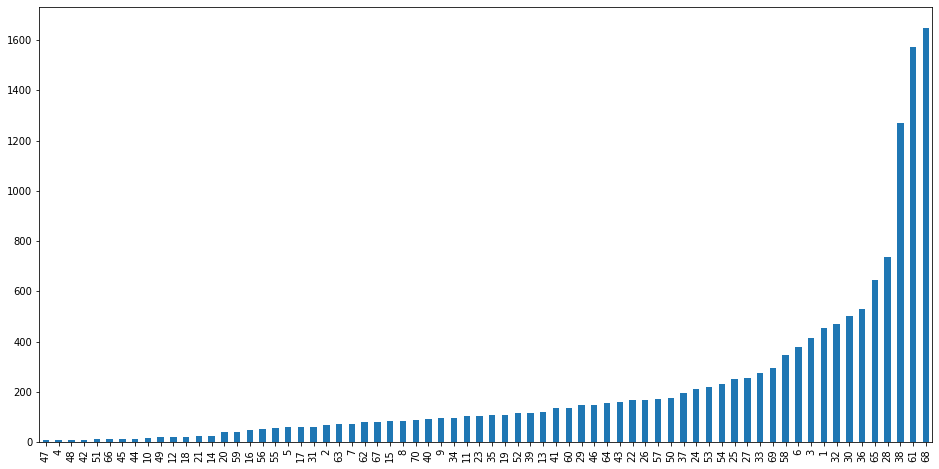

In [189]:
t2s = pd.Series(dict_t2s)
t2s.sort_values(inplace=True)
t2s.plot(kind='bar', figsize=(16,8))

Depending on how emotions are assigned to the topics, we could be looking at some label imbalances.
Anyway, let's not get ahead of ourselves, let's look at what topics are assigned to some of the songs:

In [199]:
display_utils.display_song_topics(['Love The Way You Lie', 'Marvins Room'], df)
display_utils.display_song_emotions(['Love The Way You Lie', 'Marvins Room'], df)

,song,artist,topics
2345,Marvins Room,Drake,"[38, 65, 68]"
2447,Love The Way You Lie,Eminem,"[30, 61]"


,song,artist,joy,trust,sadness,disgust,anger,fear,anticipation,surprise
2345,Marvins Room,Drake,0,0,0,0,0,0,0,0
2447,Love The Way You Lie,Eminem,0,0,0,0,0,0,0,0


# Emotion Annotation

In [ ]:
from nltk import PorterStemmer
ps = PorterStemmer()

df_w2e['stem'] = df_w2e['word'].apply(lambda x: ps.stem(x))
df_w2e_stemmed = df_w2e[['stem', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]
df_w2e_stemmed = df_w2e_stemmed.groupby('stem').sum()

words_w2e_stemmed = df_w2e_stemmed.index.tolist()

In [200]:
df_t2e = pd.DataFrame()

words_top = data_utils.get_top_words_for_each_topic(topic_model, vectorizer.get_feature_names(), 50)
word_count = 0
matched_word_count = 0

for t in range(len(words_top)):
    wordset = set(words_top[t])
    t_word_count = 0
    t_matched_word_count =  0
    for word in words_top[t]:
        wordset.update(data_utils.get_similar_words(w2v_model, word, 0.6))
    for word in wordset:
        word_count +=  1
        t_word_count +=  1
        word = ps.stem(word)
        if word in words_w2e_stemmed:
            word_i = words_w2e_stemmed.index(word)
            matched_word_count +=  1
            t_matched_word_count +=  1
        
            df_temp = df_w2e_stemmed.loc[words_w2e_stemmed[word_i:word_i+1]][
                ['anger', 'anticipation', 'fear', 'joy', 'sadness', 'trust']] 
            # dropping 'surprise' and 'disgust' because they are difficult to manually identify
            # also because they are less relevant
            df_temp['topic'] = t
            df_t2e=df_t2e.append(df_temp)
    print("{0} words matched out of {1} words for Topic {2}, ({3}%)".format(t_matched_word_count, t_word_count, t+1,
                                                                            round(t_matched_word_count/t_word_count*100)))

print("{0} words matched out of {1} words in total.\nThat's about {2}% matches.".format(
    matched_word_count, word_count, round(matched_word_count/word_count*100)))

145 words matched out of 262 words for Topic 1, (55%)
127 words matched out of 289 words for Topic 2, (44%)
65 words matched out of 224 words for Topic 3, (29%)
130 words matched out of 250 words for Topic 4, (52%)
99 words matched out of 286 words for Topic 5, (35%)
108 words matched out of 242 words for Topic 6, (45%)
81 words matched out of 248 words for Topic 7, (33%)
127 words matched out of 291 words for Topic 8, (44%)
92 words matched out of 236 words for Topic 9, (39%)
80 words matched out of 262 words for Topic 10, (31%)
93 words matched out of 260 words for Topic 11, (36%)
109 words matched out of 240 words for Topic 12, (45%)
98 words matched out of 257 words for Topic 13, (38%)
124 words matched out of 296 words for Topic 14, (42%)
118 words matched out of 285 words for Topic 15, (41%)
85 words matched out of 287 words for Topic 16, (30%)
111 words matched out of 289 words for Topic 17, (38%)
97 words matched out of 277 words for Topic 18, (35%)
138 words matched out of 278

In [201]:
top_word = data_utils.get_top_words_for_each_topic(topic_model, vectorizer.get_feature_names(), 5)

In [423]:
def get_prominent_emotions(row, threshold=0.9):
    prominent = max(row)
    match_count = sum(row)
    row = (row/prominent)
    row['prominent_emotions'] = [index for index, value in row.iteritems() if value >= threshold]
    row['match_count'] = match_count
    return row

In [424]:
df_t2e_grouped = df_t2e.groupby('topic').sum()
df_t2e_assigned = df_t2e_grouped.apply(get_prominent_emotions, axis=1)
df_t2e_assigned.index = df_t2e_assigned.index + 1
display(df_t2e_assigned)

,anger,anticipation,fear,joy,sadness,trust,prominent_emotions,match_count
topic,,,,,,,,
1,0.626506,0.626506,0.831325,0.674699,1.000000,0.746988,[sadness],374.0
2,0.645161,0.725806,0.838710,0.516129,0.854839,1.000000,[trust],284.0
3,1.000000,0.538462,0.884615,0.384615,0.807692,0.884615,[anger],117.0
4,0.666667,0.666667,1.000000,0.750000,0.861111,0.916667,"[fear, trust]",350.0
5,1.000000,0.642857,1.000000,0.595238,0.833333,0.880952,"[anger, fear]",208.0
...,...,...,...,...,...,...,...,...
66,0.880952,0.761905,1.000000,0.833333,0.976190,0.738095,"[fear, sadness]",218.0
67,0.592593,0.981481,0.685185,0.888889,0.833333,1.000000,"[anticipation, trust]",269.0
68,1.000000,0.545455,0.818182,0.484848,0.757576,0.818182,[anger],146.0


The graph below shows the number of topics an emotion is present in:

<BarContainer object of 6 artists>

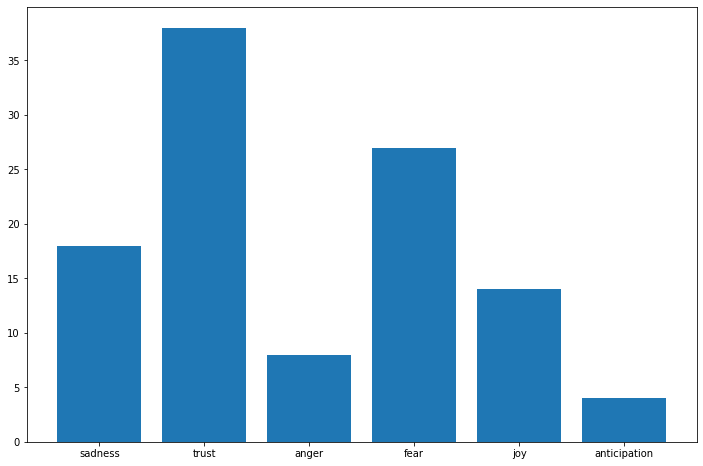

In [425]:
from collections import Counter

flattened_emotions = ([emotion for emotions in df_t2e_assigned.prominent_emotions.values for emotion in emotions])
flattened_emotions_count = Counter(flattened_emotions)

plt.figure(figsize=(12,8))
plt.bar(flattened_emotions_count.keys(), flattened_emotions_count.values())

In [426]:
def assign_prominent_emotions(row):
    keywords = []
    global df_t2e_assigned
    topics = row['topics']
#     print(topics)
    for topic in topics:
#         print(topic)
        keywords.append(top_word[int(topic)])
        emotions = df_t2e_assigned.at[topic+1, 'prominent_emotions']
        for emotion in emotions:
            row[emotion] = int(1)
    row['topic_keywords']= keywords
    return row

def assign_prominent_topics(row):
    keywords = []
    global df_t2e_assigned
    topics = row['topics']
    for topic in topics:
        if topic in labels_dict:
            for label in labels_dict[topic]:
                row[label] = 1
    return row


# df_t2e_assigned.index = df_t2e_assigned.index - 1
df = df.apply(assign_prominent_emotions, axis=1).fillna(int(0))
df = df.apply(assign_prominent_topics, axis=1).fillna(int(0))
df.to_csv('labeled_data.csv', encoding='utf-8', index=True)

In [226]:
importlib.reload(display_utils)

<module 'display_utils' from '/Users/huzefaraja/projects/nlp/mireal/display_utils.py'>

In [427]:
display_utils.display_song_topics(['Love The Way You Lie', 'Marvins Room'], df)
temp = display_utils.display_song_topics(['Love The Way You Lie', 'Marvins Room'], df, set_of_labels, True)
display_utils.display_song_emotions(['Love The Way You Lie', 'Marvins Room'], df)

,song,artist,topics
2345,Marvins Room,Drake,"[38, 65, 68]"
2447,Love The Way You Lie,Eminem,"[30, 61]"


,Drake - Marvins Room,Eminem - Love The Way You Lie
song,Marvins Room,Love The Way You Lie
artist,Drake,Eminem
topics,"[38, 65, 68]","[30, 61]"
anger,1,0
city,0,0
death,0,0
dreams,0,0
drinking,0,0
enjoyment,0,0
family,1,0


,song,artist,joy,trust,sadness,disgust,anger,fear,anticipation,surprise
2345,Marvins Room,Drake,0,1,0,0,1,1,0,0
2447,Love The Way You Lie,Eminem,1,1,1,0,0,0,0,0


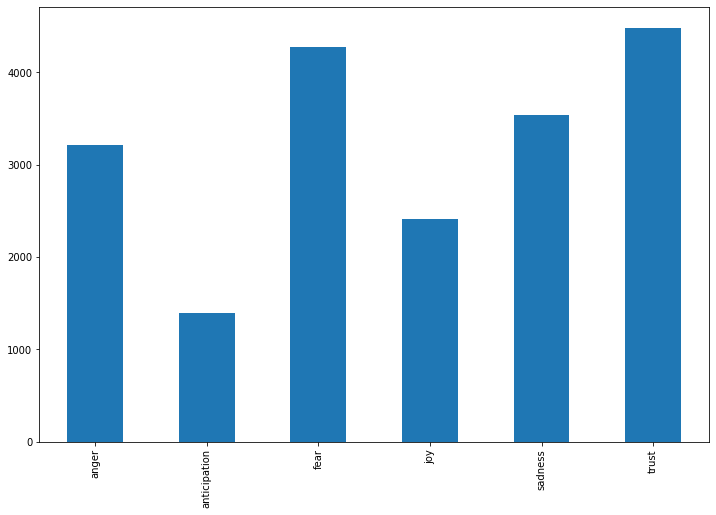

In [428]:
df[ ['anger', 'anticipation', 'fear', 'joy', 'sadness', 'trust']].sum().plot(kind='bar', figsize=(12,8))

In [461]:
temp

,Drake - Marvins Room,Eminem - Love The Way You Lie
song,Marvins Room,Love The Way You Lie
artist,Drake,Eminem
topics,"[38, 65, 68]","[30, 61]"
anger,1,0
city,0,0
death,0,0
dreams,0,0
drinking,0,0
enjoyment,0,0
family,1,0


# Classification


# Benchmark Classifiers

In [229]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

def fscore(y_true, y_pred):
    return fbeta_score(y_true, y_pred, average='weighted', beta=0.5)

In [230]:
x, y = lyrics_vectorized.toarray(), df[['trust','anger','anticipation','fear','joy','sadness',*list(sorted(set_of_labels))]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=4)
print("Input shape: {}, output shape: {}".format(x_train.shape, y_train.shape))

Input shape: (3799, 2808), output shape: (3799, 29)


In [231]:
classifiers = {
    'OneVsRestClassifier_SVC' : OneVsRestClassifier(SVC(kernel='linear', random_state=4),n_jobs=-1),
    'OneVsRestClassifier_Perceptron' : OneVsRestClassifier(Perceptron(random_state=4),n_jobs=-1),
    'MLPClassifier' : MLPClassifier(random_state=4)
}

In [232]:
for clf_name, clf in classifiers.items():
    print()
    print(clf_name + ":")
    
    last = now()
    clf.fit(x_train, y_train)
    print('Time taken for training = ', end='')
    display_utils.print_time(now()-last)

    last = now()
    y_pred = clf.predict(x_test)
    print('Time taken for prediction = ', end='')
    display_utils.print_time(now()-last)
    
    print('F-Score = ', end='')
    print(fscore(y_test, y_pred))
    
    print()


OneVsRestClassifier_SVC:
Time taken for training = 2m 34s 331ms
Time taken for prediction = 58s 762ms
F-Score = 0.7179013743932848


OneVsRestClassifier_Perceptron:
Time taken for training = 3s 823ms
Time taken for prediction = 154ms
F-Score = 0.7294592913350766


MLPClassifier:
Time taken for training = 43s 968ms
Time taken for prediction = 21ms
F-Score = 0.761742606830127



In [233]:
# !pip install keras
!pip install tensorflow

You should consider upgrading via the 'pip install --upgrade pip' command.


# The Final Model

In [234]:
from keras.callbacks import Callback, ModelCheckpoint

class F1BetaCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.df = pd.DataFrame()

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test = self.test_data
        y_pred = model.predict(x_test)
        y_pred[y_pred>=0.5] = 1
        y_pred[y_pred<0.5] = 0
        logs['f1_score']=fscore(y_test, y_pred)
        self.df = self.df.append({'epoch':epoch, 'f1_score':logs['f1_score']}, ignore_index=True)

Using TensorFlow backend.
/Users/huzefaraja/.virtualenvs/nlp/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from google.protobuf.pyext import _message


In [247]:

from keras import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.initializers import TruncatedNormal
from keras.regularizers import l1_l2
from keras.optimizers import SGD, Adam

model = Sequential()
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

model.add(Dense(256, activation='relu', input_dim=input_dim))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(output_dim, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

filepath="weights.best"
checkpoint = ModelCheckpoint(filepath, monitor='f1_score', verbose=1, save_best_only=True, mode='max')
f1test = F1BetaCallback((x_test, y_test))
last = now()
model_hist = model.fit(x_train, y_train, 
                       epochs=20, 
                       batch_size=256, verbose=1,
                       callbacks=[f1test, checkpoint], 
                       shuffle=True)
print("Total time taken for training: ",  end='')
display_utils.print_time(now() - last)
display(f1test.df.describe())
model.save_weights('weights.last')
pd.DataFrame(model_hist.history)

Epoch 1/20
3799/3799 [==============================] - 1s 136us/step - loss: 0.4585

Epoch 00001: f1_score improved from -inf to 0.60647, saving model to weights.best
Epoch 2/20
3799/3799 [==============================] - 0s 74us/step - loss: 0.3117

Epoch 00002: f1_score improved from 0.60647 to 0.66261, saving model to weights.best
Epoch 3/20
3799/3799 [==============================] - 0s 72us/step - loss: 0.2516

Epoch 00003: f1_score improved from 0.66261 to 0.74257, saving model to weights.best
Epoch 4/20
3799/3799 [==============================] - 0s 71us/step - loss: 0.2035

Epoch 00004: f1_score improved from 0.74257 to 0.76560, saving model to weights.best
Epoch 5/20
3799/3799 [==============================] - 0s 70us/step - loss: 0.1624

Epoch 00005: f1_score improved from 0.76560 to 0.77355, saving model to weights.best
Epoch 6/20
3799/3799 [==============================] - 0s 71us/step - loss: 0.1289

Epoch 00006: f1_score improved from 0.77355 to 0.79015, saving mode

,epoch,f1_score
count,20.00000,20.000000
mean,9.50000,0.770886
std,5.91608,0.049096
min,0.00000,0.606472
25%,4.75000,0.784948
50%,9.50000,0.789745
75%,14.25000,0.792153
max,19.00000,0.795833


,loss,f1_score
0,0.458503,0.606472
1,0.311684,0.662613
2,0.251626,0.742573
3,0.203473,0.765599
4,0.162431,0.773551
5,0.128872,0.790148
6,0.102343,0.789429
7,0.080635,0.792925
8,0.066597,0.790788
9,0.053752,0.793189


In [248]:
print("F-score with final weights: ", end='')
model.load_weights('weights.last')
preds = model.predict(x_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0
print(fscore(y_test, preds))

print("F-score with the best weights: ", end='')
model.load_weights('weights.best')
preds = model.predict(x_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0
print(fscore(y_test, preds))

F-score with final weights: 0.7921903618070505
F-score with the best weights: 0.7958325290407414


In [249]:
print("F-scores for each epoch: ")
f1test.df.epoch = f1test.df.epoch.astype(int)
f1test.df.set_index('epoch')

F-scores for each epoch: 


,f1_score
epoch,
0,0.606472
1,0.662613
2,0.742573
3,0.765599
4,0.773551
5,0.790148
6,0.789429
7,0.792925
8,0.790788


## Lyrics Genius API

In [238]:
!pip install lyricsgenius

You should consider upgrading via the 'pip install --upgrade pip' command.


In [289]:
import lyricsgenius
genius = lyricsgenius.Genius("dU0w3p_pSek4AvwkaiqKGwl05lMqIl1jVWhax3S66imLphoiO4UqLDJjsZwyXzZy", verbose=False)
ACCESS_TOKEN = "dU0w3p_pSek4AvwkaiqKGwl05lMqIl1jVWhax3S66imLphoiO4UqLDJjsZwyXzZy"

In [242]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [241]:
import re

def clean_song(song):
    return '\n'.join(line.strip() for line in re.sub(' +', ' ', re.sub('[^a-zA-Z0-9 \',?!;\n]', ' ', song)).splitlines())

In [79]:
df = pd.read_csv("labeled_data.csv")

In [292]:
import requests
import json
def search_song(query, lyrics=""):
    response = requests.get("http://api.genius.com/search?q={}&access_token={}".format(query, ACCESS_TOKEN))
    response_json = json.loads(response.content)
    underscored_line = ''.join(["_" for _ in range(117)])
    first = None
    output = None
    try:
        first = response_json['response']['hits'][0]
    except e as Exception:
        first = None
    if first is not None:
        if first['type'] == 'song':
            song_output = {}
            song_text = ""
            song_id = first['result']['id']
            title = first['result']['title']
            artist = first['result']['primary_artist']['name']
            annotation_count = first['result']['annotation_count']
            
            song_lyrics = genius.search_song(query)
            if song_lyrics is not None:
                output = song_lyrics.lyrics
            else:
                output = lyrics
            
            output += "\n"
            
            song_response = requests.get("http://api.genius.com/songs/{}?access_token={}&text_format=plain".format(song_id, ACCESS_TOKEN))
            song_response_json = json.loads(song_response.content)
            song_description = song_response_json['response']['song']['description']['plain']
            
            output += song_description
            output += "\n"
            
            
            referent_response = requests.get("http://api.genius.com/referents?song_id={}&access_token={}&text_format=plain".format(song_id, ACCESS_TOKEN))
            referent_response_json = json.loads(referent_response.content)
            
            for referent in referent_response_json['response']['referents']:
                output += referent['fragment']
                output += "\n"
                        
                for annotation in referent['annotations']:
                    if 'plain' in annotation['body']:
                        output += annotation['body']['plain']
                        output += "\n"
#             return song_response_json, referent_response_json
        else:
            output = lyrics
    else:
        output = lyrics
    output = re.sub("\n+", "\n", output)
    return output

In [325]:
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

In [356]:
df_sample = df.sample(400, random_state=42)
df_sample = pd.concat([df_sample, df[df.song=="Love The Way You Lie"], df[df.song=="Marvins Room"]])
songs = {}

In [370]:
cleaned_songs = {}

In [369]:
def get_cleaned_song(songs, cleaned_songs, song):
    if song not in cleaned_songs:
        cleaned_songs[song] = clean_song(songs[song])
    return cleaned_songs[song]

In [358]:
songs_to_skip = len(songs)
total_songs = len(df_sample)
print("Total songs: ", total_songs)
songs_downloaded = 0
for index, song in df_sample.iterrows():
    if songs_downloaded >= songs_to_skip:
        title = song['song']
        artist = song['artist']
        cleaned_lyrics = song['cleaned_lyrics']
        query = artist + " " + title
        try:
            text = search_song(query, cleaned_lyrics)
            songs[query] = text
        except Exception as e:
            print("Exception while getting", query)
            songs[query] = cleaned_lyrics # fall back to cleaned lyrics in case we can't get from genius
    songs_downloaded += 1
    if songs_downloaded % 100 == 0:
        print("Completed {} songs".format(songs_downloaded))

Total songs:  402
Completed 100 songs
Completed 200 songs
Completed 300 songs
Completed 400 songs


In [359]:
len(songs)

402

## Bootstrapping

In [360]:
feature_names = vectorizer.get_feature_names()
n_top_words = 5

In [361]:
def get_top_words(model, feature_names, n_top_words):
    words = []
    for topic_idx, topic in enumerate(model.components_):
        message = " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        words.extend(message.split())
    return words

### Non-Restrictive Bootstrapping

In [254]:
seeds = set(get_top_words(topic_model, feature_names, n_top_words))
extraction_patterns_to_avoid = set(['CCONJ', 'SPACE', 'PUNCT', 'PART'])
extraction_patterns = []
extraction_patterns_details = {}

In [364]:
for song in songs:
    analyzed_song = nlp(get_cleaned_song(songs, cleaned_songs, song))
    for sent in analyzed_song.sents:
        for token in sent:
            if token.text in seeds or token.lemma_ in seeds:
                pattern = []
                i = 0
                _pattern_seeds = []
                _pattern_seed_indexes = []
                for _token in sent:
                    if _token.pos_ not in extraction_patterns_to_avoid:
                        if _token.text in seeds or _token.lemma_ in seeds:
                            pattern.append(str(_token.pos_).lower())
                            _pattern_seeds.append(_token.lemma_)
                            _pattern_seed_indexes.append(i)
                        else:
                            pattern.append(str(_token.pos_).lower())
                        i+=1
                pattern = ','.join(pattern)
                if pattern in extraction_patterns_details:
                    for i in range(len(_pattern_seeds)):
                        _seed = _pattern_seeds[i]
                        _seed_index = _pattern_seed_indexes[i]
                        if _seed in extraction_patterns_details[pattern]:
                            extraction_patterns_details[pattern][_seed].add(_seed_index)
                        else:
                            extraction_patterns_details[pattern][_seed] = set([_seed_index])
                else:
                    extraction_patterns_details[pattern] = {}
                    for i in range(len(_pattern_seeds)):
                        _seed = _pattern_seeds[i]
                        _seed_index = _pattern_seed_indexes[i]
                        if _seed in extraction_patterns_details[pattern]:
                            extraction_patterns_details[pattern][_seed].add(_seed_index)
                        else:
                            extraction_patterns_details[pattern][_seed] = set([_seed_index])
                extraction_patterns.append(pattern)
                break

In [368]:
extraction_patterns = set(extraction_patterns)
len(extraction_patterns)

14655

In [373]:
extraction_pattern_details = extraction_patterns_details  # fixing typo, do not wish to search pattern again

In [374]:
extraction_patterns_for_line = []
extraction_pattern_details_for_line = {}

In [375]:
for song in songs:
    for line in get_cleaned_song(songs, cleaned_songs, song).splitlines():
        analyzed_line = nlp(line)
        for sent in analyzed_line.sents:
            for token in sent:
                if token.text in seeds or token.lemma_ in seeds:
                    pattern = []
                    i = 0
                    _pattern_seeds = []
                    _pattern_seed_indexes = []
                    for _token in sent:
                        if _token.pos_ not in extraction_patterns_to_avoid:
                            if _token.text in seeds or _token.lemma_ in seeds:
                                pattern.append(str(_token.pos_).lower())
                                _pattern_seeds.append(_token.lemma_)
                                _pattern_seed_indexes.append(i)
                            else:
                                pattern.append(str(_token.pos_).lower())
                            i+=1
                    pattern = ','.join(pattern)
                    if pattern in extraction_pattern_details_for_line:
                        for i in range(len(_pattern_seeds)):
                            _seed = _pattern_seeds[i]
                            _seed_index = _pattern_seed_indexes[i]
                            if _seed in extraction_pattern_details_for_line[pattern]:
                                extraction_pattern_details_for_line[pattern][_seed].add(_seed_index)
                            else:
                                extraction_pattern_details_for_line[pattern][_seed] = set([_seed_index])
                    else:
                        extraction_pattern_details_for_line[pattern] = {}
                        for i in range(len(_pattern_seeds)):
                            _seed = _pattern_seeds[i]
                            _seed_index = _pattern_seed_indexes[i]
                            if _seed in extraction_pattern_details_for_line[pattern]:
                                extraction_pattern_details_for_line[pattern][_seed].add(_seed_index)
                            else:
                                extraction_pattern_details_for_line[pattern][_seed] = set([_seed_index])
                    extraction_patterns_for_line.append(pattern)
                    break

In [376]:
extraction_patterns_for_line = set(extraction_patterns_for_line)
len(extraction_patterns_for_line)

14790

In [378]:
seeds_to_augments = {}

In [385]:
for song in songs:
    analyzed_song = nlp(get_cleaned_song(songs, cleaned_songs, song))
    for sent in analyzed_song.sents:
        pattern = []
        tokens = []
        for token in sent:
            if token.pos_ not in extraction_patterns_to_avoid:
                pattern.append(str(token.pos_).lower())
                tokens.append(token.lemma_)
        pattern = ",".join(pattern)
        if pattern in extraction_patterns:
            for seed in extraction_pattern_details[pattern]:
                seed = seed.lower()
                if seed in seeds_to_augments:
                    for index in extraction_pattern_details[pattern][seed]:
                        seeds_to_augments[seed].add(tokens[index])
                else:
                    seeds_to_augments[seed] = set()
                    for index in extraction_pattern_details[pattern][seed]:
                        seeds_to_augments[seed].add(tokens[index])

In [389]:
# number of words that could be in place of "love"
len(seeds_to_augments['love'])

1084

In [392]:
# number of words that could be in place of "night"
len(seeds_to_augments['night'])

424

In [393]:
# number of words that could be in place of "night"
len(seeds_to_augments['happy'])

55

In [394]:
seeds_to_augments['happy']

{'alive',
 'alone',
 'anti',
 'believable',
 'big',
 'chorus',
 'common',
 'cool',
 'creative',
 'd',
 'damn',
 'dead',
 'drunk',
 'dypegdes3o',
 'fabolous',
 'faithless',
 'funny',
 'happy',
 'hard',
 'harsh',
 'high',
 'hot',
 'hush',
 'instrumental',
 'ironic',
 'kuchi',
 'low',
 'mad',
 'magnificent',
 'nice',
 'other',
 'outtie',
 'personal',
 'private',
 'puffy',
 'ready',
 'right',
 'safe',
 'senseless',
 'serene',
 'sexy',
 'silly',
 'single',
 'sober',
 'square',
 'sweet',
 'tall',
 'true',
 'un',
 'unforgettable',
 'wet',
 'xxxscr3w3dupxxx',
 'yearly',
 'young',
 'zoom'}

In [395]:
for song in songs:
    lines = get_cleaned_song(songs, cleaned_songs, song)
    for line in lines.splitlines():
        analyzed_line = nlp(line)
        for sent in analyzed_song.sents:
            pattern = []
            tokens = []
            for token in sent:
                if token.pos_ not in extraction_patterns_to_avoid:
                    pattern.append(str(token.pos_).lower())
                    tokens.append(token.lemma_)
            pattern = ",".join(pattern)
            if pattern in extraction_patterns:
                for seed in extraction_pattern_details[pattern]:
                    seed = seed.lower()
                    if seed in seeds_to_augments:
                        for index in extraction_pattern_details[pattern][seed]:
                            seeds_to_augments[seed].add(tokens[index])
                    else:
                        seeds_to_augments[seed] = set()
                        for index in extraction_pattern_details[pattern][seed]:
                            seeds_to_augments[seed].add(tokens[index])

### Restrictive Bootstrapping

In [490]:
r_extraction_pattern_details = {}
r_extraction_patterns = []

In [491]:
for song in songs:
    analyzed_song = nlp(get_cleaned_song(songs, cleaned_songs, song))
    for sent in analyzed_song.sents:
        for token in sent:
            if token.text in seeds or token.lemma_ in seeds:
                pre_tokens = []
                post_tokens = []
                is_pre_complete = False
                seed_token = None
                for _token in sent:
                    if _token.pos_ not in extraction_patterns_to_avoid:
                        if not is_pre_complete:
                            if _token.text in seeds or _token.lemma_ in seeds:
                                is_pre_complete = True
                                seed_token = _token.lemma_
                                continue
                        if is_pre_complete:
                            post_tokens.append(_token.lemma_)
                        else:
                            pre_tokens.append(_token.lemma_)
                            
                pattern_start = ','.join(pre_tokens)
                pattern_end = ",".join(post_tokens)

                if pattern_start in r_extraction_pattern_details:
#                     if seed_token in r_extraction_pattern_details[pattern_start]:
#                         r_extraction_pattern_details[pattern_start][seed_token].add(pattern_end)
#                     else:
#                         r_extraction_pattern_details[pattern_start][seed_token] = set()
#                         r_extraction_pattern_details[pattern_start][seed_token].add(pattern_end)
                    
                    if pattern_end in r_extraction_pattern_details[pattern_start]:
                        r_extraction_pattern_details[pattern_start][pattern_end].add(seed_token)
                    else:
                        r_extraction_pattern_details[pattern_start][pattern_end] = set()
                        r_extraction_pattern_details[pattern_start][pattern_end].add(seed_token)
                else:
                    r_extraction_pattern_details[pattern_start] = {
#                         seed_token: set([pattern_end]), 
                        pattern_end: set([seed_token])}
                break

In [493]:
len(r_extraction_pattern_details)

10907

In [549]:
r_seeds_to_augments = {}

In [550]:
for song in songs:
    analyzed_song = nlp(get_cleaned_song(songs, cleaned_songs, song))
    for sent in analyzed_song.sents:
        pre_tokens = []
        is_pre_complete = False
        for i in range(len(sent)):
            token = sent[i]
            if token.pos_ not in extraction_patterns_to_avoid:
                pre_tokens.append(token.lemma_)
                pattern = ",".join(pre_tokens)
                if i < len(sent) - 2:
                    word = sent[i+1].lemma_.lower()
                    if pattern in r_extraction_pattern_details:
                        post_tokens = []
                        for j in range(i+2, len(sent)):
                            _token = sent[j]
                            if _token.pos_ not in extraction_patterns_to_avoid:
                                post_tokens.append(token.lemma_)
                                post_pattern = ",".join(post_tokens)
                                if post_pattern in r_extraction_pattern_details[pattern]:
                                    for seed in r_extraction_pattern_details[pattern][post_pattern]:
                                        if seed in r_seeds_to_augments:
                                            r_seeds_to_augments[seed].add(word)
                                        else:
                                            r_seeds_to_augments[seed] = set()
                                            r_seeds_to_augments[seed].add(word)

In [551]:
r_seeds_to_augments.keys()

dict_keys(['smell', 'watch', 'love', 'lose', 'hear', 'play', 'meet', 'open', 'believe', 'hold', 'shake', 'leave', 'feel', 'hell', 'body', 'pool', 'hit', 'fit', 'save', 'tear', 'mirror', 'help', 'round', 'young', 'kiss', 'check', 'suppose', 'catch'])

In [552]:
r_seeds_to_augments['mirror']

{'be', 'mirror', 'speak'}

In [553]:
[word for word in r_seeds_to_augments['watch'] if len(word)>3][:10]

['woman',
 'slang',
 'satisfy',
 'mouth',
 'count',
 'rain',
 'must',
 'mobile',
 'wail',
 'already']

In [554]:
[word for word in r_seeds_to_augments['feel'] if len(word)>3][:25]

['life',
 'find',
 'fail',
 'throw',
 'momma',
 'clear',
 'change',
 'leave',
 'just',
 'would',
 'irritate',
 'love',
 'have',
 'make',
 'forget',
 'sound',
 'take',
 'choose',
 'like',
 'ever',
 'tell',
 'plan',
 'keep',
 'fight',
 'will']

In [555]:
[word for word in r_seeds_to_augments['mirror'] if len(word)>3][:10]

['mirror', 'speak']

In [556]:
[word for word in r_seeds_to_augments['catch'] if len(word)>3][:10]

['catch']

In [557]:
[word for word in r_seeds_to_augments['body'] if len(word)>3][:25]

['like',
 'hate',
 'free',
 'body',
 'sorry',
 'really',
 'stand',
 'thirty',
 'sittin',
 'reproduce',
 'just',
 'hold',
 'gettin',
 'solo',
 'only',
 'digital',
 'bounce',
 'freedom',
 'reminisce']

In [558]:
[word for word in r_seeds_to_augments['fit'] if len(word)>=3][:10]

['fit']